# Tema 7 - Ejercicio SVM

La base de datos incluida en el archivo Bank.csv (dentro de Bank.zip)
recoge información de 4.521 clientes a los que se les ofreció contratar un
depósito a plazo en una entidad bancaria portuguesa (el zip también
contiene un fichero de texto denominado Bank-names.txt con el detalle
completo de todas las variables incluidas)
Utilizando dicha base de datos, elabore una red neuronal que permita
pronosticar si, en base a sus características, el cliente contratará el
depósito o no.

De cara a la realización de este ejercicio, debe tener en cuenta que:

- La variable objetivo de nuestro modelo es “y”, la cual tiene el valor
“yes” si el cliente ha contratado el depósito y “no” en caso contrario.

- Observe que hay múltiples variable de tipo cualitativo que deberá
transformar antes de estimar el modelo.

- No olvide normalizar los datos antes de introducirlos en el modelo.
  



Importamos dependencias

In [1]:
import pandas as pd # to load and manipulate data and for One-Hot Encoding
import numpy as np # to calculate the mean and standard deviation
import matplotlib.pyplot as plt 
import matplotlib.colors as colors

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import scale  
from sklearn.model_selection import GridSearchCV # this will do cross validation (grid search cross validation)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.svm import SVC  # SVM for classification

# Extra?
#from sklearn.decomposition import PCA # to perform PCA to plot the data

## Paso 1: importar datos

In [2]:
## import data
bank_raw = pd.read_csv(r"./Bank/bank.csv",sep=';')

## Paso 2: explorar y procesar datos

In [3]:
# explore and prepare data
bank_raw.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [4]:
bank_raw.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


In [5]:
# To show the categorical variables
bank_raw.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521
unique,12,3,4,2,2,2,3,12,4,2
top,management,married,secondary,no,yes,no,cellular,may,unknown,no
freq,969,2797,2306,4445,2559,3830,2896,1398,3705,4000


In [6]:
#check  if categorical variables contain strange values, there are missing values ..
print(bank_raw['job'].unique())
print(bank_raw['marital'].unique())
print(bank_raw['education'].unique())
print(bank_raw['default'].unique())
print(bank_raw['housing'].unique())
print(bank_raw['loan'].unique())
print(bank_raw['contact'].unique())
print(bank_raw['month'].unique())
print(bank_raw['poutcome'].unique())
print(bank_raw['y'].unique())

['unemployed' 'services' 'management' 'blue-collar' 'self-employed'
 'technician' 'entrepreneur' 'admin.' 'student' 'housemaid' 'retired'
 'unknown']
['married' 'single' 'divorced']
['primary' 'secondary' 'tertiary' 'unknown']
['no' 'yes']
['no' 'yes']
['no' 'yes']
['cellular' 'unknown' 'telephone']
['oct' 'may' 'apr' 'jun' 'feb' 'aug' 'jan' 'jul' 'nov' 'sep' 'mar' 'dec']
['unknown' 'failure' 'other' 'success']
['no' 'yes']


En principio no hay ningún problema.

Ahora toca separar la variable dependiente de las demás:

In [7]:
X=bank_raw.drop('y',axis=1).copy()
X.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown


In [8]:
y = bank_raw['y'].copy()
y.head()

0    no
1    no
2    no
3    no
4    no
Name: y, dtype: object

SVM no acepta variables categóricas, así que las trasformamos en variables numéricas mediante la técnica conocida como "**hot encoding**": </br>
(La variable month la vamos a codificar con valores de 1 a 12, para no añadir 12 columnas).

In [9]:
X_encoded=pd.get_dummies(X, columns=['job','marital','education','default','housing','loan','contact','poutcome'], dtype='int')
X_encoded.head()

,age,balance,day,month,duration,campaign,pdays,previous,job_admin.,job_blue-collar,...,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,30,1787,19,oct,79,1,-1,0,0,0,...,0,1,0,1,0,0,0,0,0,1
1,33,4789,11,may,220,1,339,4,0,0,...,1,0,1,1,0,0,1,0,0,0
2,35,1350,16,apr,185,1,330,1,0,0,...,1,1,0,1,0,0,1,0,0,0
3,30,1476,3,jun,199,4,-1,0,0,0,...,1,0,1,0,0,1,0,0,0,1
4,59,0,5,may,226,1,-1,0,0,1,...,1,1,0,0,0,1,0,0,0,1


Ahora transformamos los meses ("Ene" -> 1, "Feb" -> 2 ...)

In [10]:
#encoding month (name to number)
from datetime import datetime
X_encoded['month'] = X_encoded['month'].apply(lambda m : datetime.strptime(m, '%b').month)
#X_encoded['month']

In [11]:
X_encoded.head()

,age,balance,day,month,duration,campaign,pdays,previous,job_admin.,job_blue-collar,...,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,30,1787,19,10,79,1,-1,0,0,0,...,0,1,0,1,0,0,0,0,0,1
1,33,4789,11,5,220,1,339,4,0,0,...,1,0,1,1,0,0,1,0,0,0
2,35,1350,16,4,185,1,330,1,0,0,...,1,1,0,1,0,0,1,0,0,0
3,30,1476,3,6,199,4,-1,0,0,0,...,1,0,1,0,0,1,0,0,0,1
4,59,0,5,5,226,1,-1,0,0,1,...,1,1,0,0,0,1,0,0,0,1


Ya solo queda normalizar las variables numéricas.

Pero primero vamos a separar los conjuntos de entrenamiento y de test (para evitar así "data leakage": que información del conjunto de entrenamiento contamine el conjunto de test).

In [12]:
%%time
X_train, X_test, y_train, y_test=train_test_split(X_encoded, y, test_size=0.25, random_state=99)

X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

CPU times: user 10.8 ms, sys: 3.88 ms, total: 14.7 ms
Wall time: 13.8 ms


In [13]:
print(X_train_scaled.shape)
print(X_test_scaled.shape)
print(y_train.shape)
print(y_test.shape)

(3390, 40)
(1131, 40)
(3390,)
(1131,)


## Paso 3: Entrenamiento del modelo

Primero construimos un modelo sencillo, con los parámetros por defecto.

In [14]:
%%time
#create classifier SVM
clf_svm=SVC(random_state=99) # kernel='rbf' by default

CPU times: user 21 μs, sys: 2 μs, total: 23 μs
Wall time: 26.5 μs


In [15]:
%%time

clf_svm.fit(X_train_scaled, y_train)

CPU times: user 199 ms, sys: 11.9 ms, total: 211 ms
Wall time: 210 ms


SVC(random_state=99)

## Paso 4: Evaluación del modelo

In [16]:
predictions = clf_svm.predict(X_test_scaled)

cm = confusion_matrix(y_test, predictions, labels=clf_svm.classes_)
cm

array([[986,  13],
       [112,  20]])

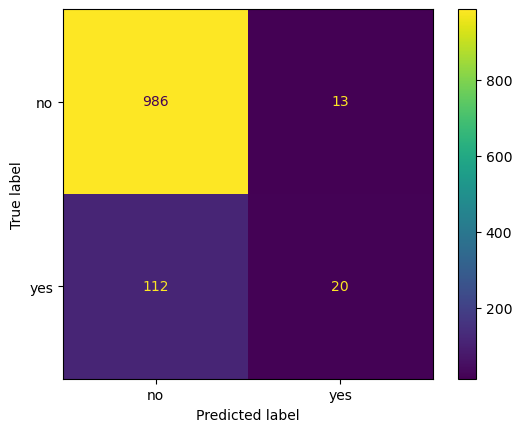

In [17]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf_svm.classes_)
disp.plot()
plt.show()

Si en lugar de colorines preferimos los valores de exactitud, recall, etc.:

In [25]:
def classifier_testing(clf, X_train, X_test, y_train, y_test):
    # Training
    clf.fit(X_train, y_train)
  
    #Predictions
    y_pred = clf.predict(X_test)

    #Accuracy
    clf_accuracy_score = round(accuracy_score(y_test, y_pred)*100, 2)
    print("Accuracy Score:\n", clf_accuracy_score, "\n")

    #Confusion Matrix
    conf_mtx = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", conf_mtx, "\n")
    
    #Classification Report
    class_rep = classification_report(y_test, y_pred)
    print("Classification Report:\n", class_rep, "\n")

In [19]:
#clf_svm=SVC(random_state=99)
#clf_svm.fit(X_train_scaled, y_train)

In [26]:
classifier_testing(clf_svm, X_train_scaled, X_test_scaled, y_train, y_test)

Accuracy Score:
 88.95 

Confusion Matrix:
 [[986  13]
 [112  20]] 

Classification Report:
               precision    recall  f1-score   support

          no       0.90      0.99      0.94       999
         yes       0.61      0.15      0.24       132

    accuracy                           0.89      1131
   macro avg       0.75      0.57      0.59      1131
weighted avg       0.86      0.89      0.86      1131
 



Se obtiene el mismo valor que en R con el kernel "vanilladot".

## Paso 5: Mejora del modelo




https://scikit-learn.org/stable/modules/svm.html#parameters-of-the-rbf-kernel :

"When training an SVM with the Radial Basis Function (RBF) kernel, two parameters must be considered: **C** and **gamma**. </br>
The parameter **C**, common to all SVM kernels, trades off misclassification of training examples against simplicity of the decision surface. A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly. </br>
**Gamma** defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected.

Proper choice of C and gamma is critical to the SVM’s performance. One is advised to use GridSearchCV with C and gamma spaced exponentially far apart to choose good values."


Hacemos así, intentamos obtener los mejores valores de C y gamma mediante la función GridSearchCV:

In [21]:
%%time
# We try to find the best C and gamma conbination
param_grid=[
    {'C': [1,10,100,1000],
     'gamma': [0.1, 0.01, 0.001, 0.0001],
     'kernel': ['rbf']},
]
optimal_params = GridSearchCV(
    SVC(),
    param_grid,
    cv=20,
    verbose=1
)
optimal_params.fit(X_train_scaled, y_train)
optimal_params.best_params_

Fitting 20 folds for each of 16 candidates, totalling 320 fits
CPU times: user 1min 9s, sys: 420 ms, total: 1min 10s
Wall time: 1min 10s


{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Entonces el mejor clasificador es:

In [22]:
clf_svm_CGamma = SVC(C=1000, gamma=0.001, random_state=99) 

In [23]:
%%time

clf_svm_CGamma.fit(X_train_scaled, y_train)

CPU times: user 536 ms, sys: 3.93 ms, total: 540 ms
Wall time: 538 ms


SVC(C=1000, gamma=0.001, random_state=99)

In [24]:
classifier_testing(clf_svm_CGamma, X_train_scaled, X_test_scaled, y_train, y_test)

Accuracy Score:
 89.57 

Confusion Matrix:
 [[973  26]
 [ 92  40]] 

Classification Report:
               precision    recall  f1-score   support

          no       0.91      0.97      0.94       999
         yes       0.61      0.30      0.40       132

    accuracy                           0.90      1131
   macro avg       0.76      0.64      0.67      1131
weighted avg       0.88      0.90      0.88      1131
 



El resultado es 89.57%, prácticamente lo mismo que lo obtenido en R (89.65%).